In [2]:
import pandas as pd
from keras.utils.vis_utils import plot_model
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow import one_hot
import load_data
import preprocess
import utils
import our_model
import sys
import io
import json

from os.path import isfile
import numpy as np
#import cupy as np
from tensorflow.keras.preprocessing.text import tokenizer_from_json 
from settings import EMBEDDING_DIM, EPOCHS, BATCH_SIZE, MODELS_DIR
#from settings import MAX_QUESTION_LENGTH, MAX_CONTEXT_LENGTH, MAX_TEXT_LENGTH

### Loading dataset and splitting

In [3]:
print("Loading dataset...")
dataframe = load_data.load_dataset()
print(dataframe.shape)

Loading dataset...
(87599, 6)


In [4]:
print("Splitting train and test set...")
train_df, test_df = load_data.split_test_set(dataframe)
print(train_df.shape, test_df.shape)

Splitting train and test set...
(78161, 6) (9438, 6)


In [5]:
print("Splitting train and validation set...")
train_df, val_df = load_data.split_validation_set(train_df, rate=0.2)
print(train_df.shape, val_df.shape)

Splitting train and validation set...
(61143, 6) (17018, 6)


### Preprocessing 

In [6]:
PREPROCESSING_PIPELINE1 = [preprocess.expand_contractions,
                           preprocess.tokenization_spacy,
                           preprocess.remove_chars,
                           preprocess.split_alpha_num_sym,
                           preprocess.spell_correction,
                           preprocess.lemmatization,
                           preprocess.lower,
                           preprocess.strip_text]

In [7]:
print("Preprocessing training data...")
train_df1 = train_df.copy()
train_df1, tr_contexts1 = preprocess.apply_preprocessing(train_df1, PREPROCESSING_PIPELINE1)

print("Preprocessing validation data...")
val_df1 = val_df.copy()
val_df1, val_contexts1 = preprocess.apply_preprocessing(val_df1, PREPROCESSING_PIPELINE1)

Preprocessing training data...
Preprocessing validation data...


### Load embedding matrices, tokenizer, word listing

In [8]:
# load already saved content or compute it from scratch
load = (isfile(f"{MODELS_DIR}/word_listing.csv") and 
        isfile(f"{MODELS_DIR}/word2idx.json") and
        isfile(f"{MODELS_DIR}/idx2word.json") and
        isfile(f"{MODELS_DIR}/tokenizer.json") and
        isfile(f"{MODELS_DIR}/embedding_matrix.npz") and
        isfile(f"{MODELS_DIR}/char_embedding_matrix.npz"))

print("load:", load)

if load:
    print("Loading matrices, tokenizers and dictionaries... ")
    #load pre-saved 
    df_word_listing = np.genfromtxt(f"{MODELS_DIR}/word_listing.csv", delimiter=',', encoding='utf-8', dtype='str')
    
    with open(f"{MODELS_DIR}/word2idx.json") as f:
        df_word_to_idx = json.load(f)

    with open(f"{MODELS_DIR}/idx2word.json") as f:
        df_idx_to_word = json.load(f)

    with open(f"{MODELS_DIR}/tokenizer.json") as f:
        tokenizer_json = json.load(f)
        df_tokenizer = tokenizer_from_json(tokenizer_json)
    
    embedding_matrix = np.load(f'{MODELS_DIR}/embedding_matrix.npz')['matrix']
    
    print("Done")
          
else:
    #compute 
    print("Computing matrices, tokenizers and dictionaries... ")
    embedding_matrix, df_word_listing, df_tokenizer, df_word_to_idx, df_idx_to_word = utils.get_embedding_matrix(train_df1, EMBEDDING_DIM)
    
    np.savez_compressed(f'{MODELS_DIR}/embedding_matrix', matrix=embedding_matrix)
    np.savetxt(f"{MODELS_DIR}/word_listing.csv", df_word_listing, delimiter=",", fmt ="%s", encoding='utf-8')

    with open(f"{MODELS_DIR}/word2idx.json", 'w') as f:
        json.dump(df_word_to_idx, f)

    with open(f"{MODELS_DIR}/idx2word.json", 'w') as f:
        json.dump(df_idx_to_word, f)

    tokenizer_json = df_tokenizer.to_json()
    with io.open(f"{MODELS_DIR}/tokenizer.json", 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    print("Done")

load: True
Loading matrices, tokenizers and dictionaries... 
Done


In [9]:
df_idx_to_word = dict(zip([int(k) for k in df_idx_to_word.keys()], df_idx_to_word.values()))

In [10]:
train_df1

,title,context,answer_start,text,question,id
0,University_of_Notre_Dame,architecturally the school ha a catholic chara...,515,saint bernadette soubirous,to whom did the virgin mary allegedly appear i...,5733be284776f41900661182
1,University_of_Notre_Dame,architecturally the school ha a catholic chara...,188,a copper statue of christ,what is in front of the notre dame main building,5733be284776f4190066117f
2,University_of_Notre_Dame,architecturally the school ha a catholic chara...,381,a marian place of prayer and reflection,what is the grotto at notre dame,5733be284776f41900661181
3,University_of_Notre_Dame,architecturally the school ha a catholic chara...,92,a golden statue of the virgin mary,what sits on top of the main building at notre...,5733be284776f4190066117e
4,University_of_Notre_Dame,as at most other university notre dame s stude...,248,september 1876,when did the scholastic magazine of notre dame...,5733bf84d058e614000b61be
...,...,...,...,...,...,...
61138,Kathmandu,kathmandu metropolitan city kmc in order to pr...,229,oregon,in what us state did kathmandu first establish...,5735d259012e2f140011a09d
61139,Kathmandu,kathmandu metropolitan city kmc in order to pr...,414,rangoon,what wa yangon previously known a,5735d259012e2f140011a09e
61140,Kathmandu,kathmandu metropolitan city kmc in order to pr...,476,minsk,with what belorussian city doe kathmandu have ...,5735d259012e2f140011a09f
61141,Kathmandu,kathmandu metropolitan city kmc in order to pr...,199,1975,in what year did kathmandu create it initial i...,5735d259012e2f140011a0a0


### Padding

In [11]:
MAX_CONTEXT_LENGTH, MAX_TEXT_LENGTH, MAX_QUESTION_LENGTH = utils.get_max_length(train_df1)

#MAX_CONTEXT_LENGTH, MAX_TEXT_LENGTH, MAX_QUESTION_LENGTH = 662, 43, 40
print("Padding data...")
tr_context_padded = utils.pad(train_df1.context, df_tokenizer, MAX_CONTEXT_LENGTH)
tr_answer_padded = utils.pad(train_df1.text, df_tokenizer, MAX_TEXT_LENGTH)
tr_question_padded = utils.pad(train_df1.question, df_tokenizer, MAX_QUESTION_LENGTH)

val_context_padded = utils.pad(val_df1.context, df_tokenizer, MAX_CONTEXT_LENGTH)
val_answer_padded = utils.pad(val_df1.text, df_tokenizer, MAX_TEXT_LENGTH)
val_question_padded = utils.pad(val_df1.question, df_tokenizer, MAX_QUESTION_LENGTH)

Max length for context is 662
Max length adopted for context is 728
Max length for answer is 43
Max length adopted for answer is 47
Max length for question is 40
Max length adopted for question is 44
Padding data...


### New start and end indices

In [12]:
print("Computing start and end indices... ")
train_df1['s_idx'] = train_df.apply(
    lambda x: len(preprocess.preprocessing(x.context[:x.answer_start], PREPROCESSING_PIPELINE1).split()), axis=1)
train_df1['e_idx'] = train_df1.apply(lambda x: x.s_idx + len(x.text.split()) - 1, axis=1)

val_df1['s_idx'] = val_df.apply(
    lambda x: len(preprocess.preprocessing(x.context[:x.answer_start], PREPROCESSING_PIPELINE1).split()), axis=1)
val_df1['e_idx'] = val_df1.apply(lambda x: x.s_idx + len(x.text.split()) - 1, axis=1)
print("Done")

Computing start and end indices... 
Done


### Exact Matching, POS, NER, Term Frequency

In [13]:
tag2idx, idx2tag = utils.create_pos_dicts()
ner2idx, idx2ner = utils.create_ner_dicts()

pos_embedding_matrix = to_categorical(list(idx2tag.keys()))
ner_embedding_matrix = to_categorical(list(idx2ner.keys()))

Creating dictionaries for POS tags...
Creating dictionaries for NER tags...


In [14]:
tr_contexts = pd.DataFrame(train_df.context.unique(), columns=['context'])
val_contexts = pd.DataFrame(val_df.context.unique(), columns=['context'])

In [15]:
print("Extracting features for Train Set")
train_em_input = utils.compute_exact_match(train_df1, MAX_CONTEXT_LENGTH)
train_tf_input = utils.compute_tf(train_df1, MAX_CONTEXT_LENGTH)
train_pos_input = utils.compute_pos(train_df1, tr_contexts1, tag2idx, MAX_CONTEXT_LENGTH)
train_ner_input = utils.compute_ner(train_df1, tr_contexts1, tr_contexts, ner2idx, MAX_CONTEXT_LENGTH)

print("Extracting features for Validation Set")
val_em_input = utils.compute_exact_match(val_df1, MAX_CONTEXT_LENGTH)
val_tf_input = utils.compute_tf(val_df1, MAX_CONTEXT_LENGTH)
val_pos_input = utils.compute_pos(val_df1, val_contexts1, tag2idx, MAX_CONTEXT_LENGTH)
val_ner_input = utils.compute_ner(val_df1, val_contexts1, val_contexts, ner2idx, MAX_CONTEXT_LENGTH)

tr_s_one = one_hot(train_df1.s_idx, depth=MAX_CONTEXT_LENGTH)
tr_e_one = one_hot(train_df1.e_idx, depth=MAX_CONTEXT_LENGTH)
val_s_one = one_hot(val_df1.s_idx, depth=MAX_CONTEXT_LENGTH)
val_e_one = one_hot(val_df1.e_idx, depth=MAX_CONTEXT_LENGTH)

x_tr = {'context': tr_context_padded, 'question': tr_question_padded, 'pos': train_pos_input,
        'ner': train_ner_input, 'em': train_em_input, 'tf': train_tf_input}
x_val = {'context': val_context_padded, 'question': val_question_padded, 'pos': val_pos_input,
         'ner': val_ner_input, 'em': val_em_input, 'tf': val_tf_input}

y_tr = {'start': tr_s_one, 'end': tr_e_one}
y_val = {'start': val_s_one, 'end': val_e_one}

Extracting features for Train Set
Computing original exact match...
Computing lowercase exact match...
Computing lemmatized exact match...
Computing TF...
Computing POS tags...
Padding POS sequences...
Computing NER tags...
Padding NER sequences...
Extracting features for Validation Set
Computing original exact match...
Computing lowercase exact match...
Computing lemmatized exact match...
Computing TF...
Computing POS tags...
Padding POS sequences...
Computing NER tags...
Padding NER sequences...


In [16]:
train_ner_input[0][:10]

array([19, 19, 19, 19, 19,  1, 19, 19,  2,  2])

In [17]:
train_pos_input[0][:10]

array([33, 12, 25, 40, 12, 18, 25, 17, 12, 18])

In [18]:
if isfile(f"{MODELS_DIR}/char_embedding_matrix.npz"):
    print('Loading char matrix')
    char_embedding_matrix = np.load(f'{MODELS_DIR}/char_embedding_matrix.npz')['matrix']
else:
    char_embedding_matrix = utils.get_char_embeddings(df_word_listing, df_word_to_idx)
    np.savez_compressed(f'{MODELS_DIR}/char_embedding_matrix', matrix=char_embedding_matrix)

Loading char matrix


### build model

In [19]:
model = our_model.build_model(MAX_QUESTION_LENGTH, MAX_CONTEXT_LENGTH, EMBEDDING_DIM, embedding_matrix, 
                              char_embedding_matrix, pos_embedding_matrix, ner_embedding_matrix)

model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics='accuracy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context (InputLayer)            [(None, 728)]        0                                            
__________________________________________________________________________________________________
question (InputLayer)           [(None, 44)]         0                                            
__________________________________________________________________________________________________
p_encoding (Embedding)          (None, 728, 100)     6524400     context[0][0]                    
__________________________________________________________________________________________________
char_p_encoding (Embedding)     (None, 728, 50)      3262200     context[0][0]                    
______________________________________________________________________________________________

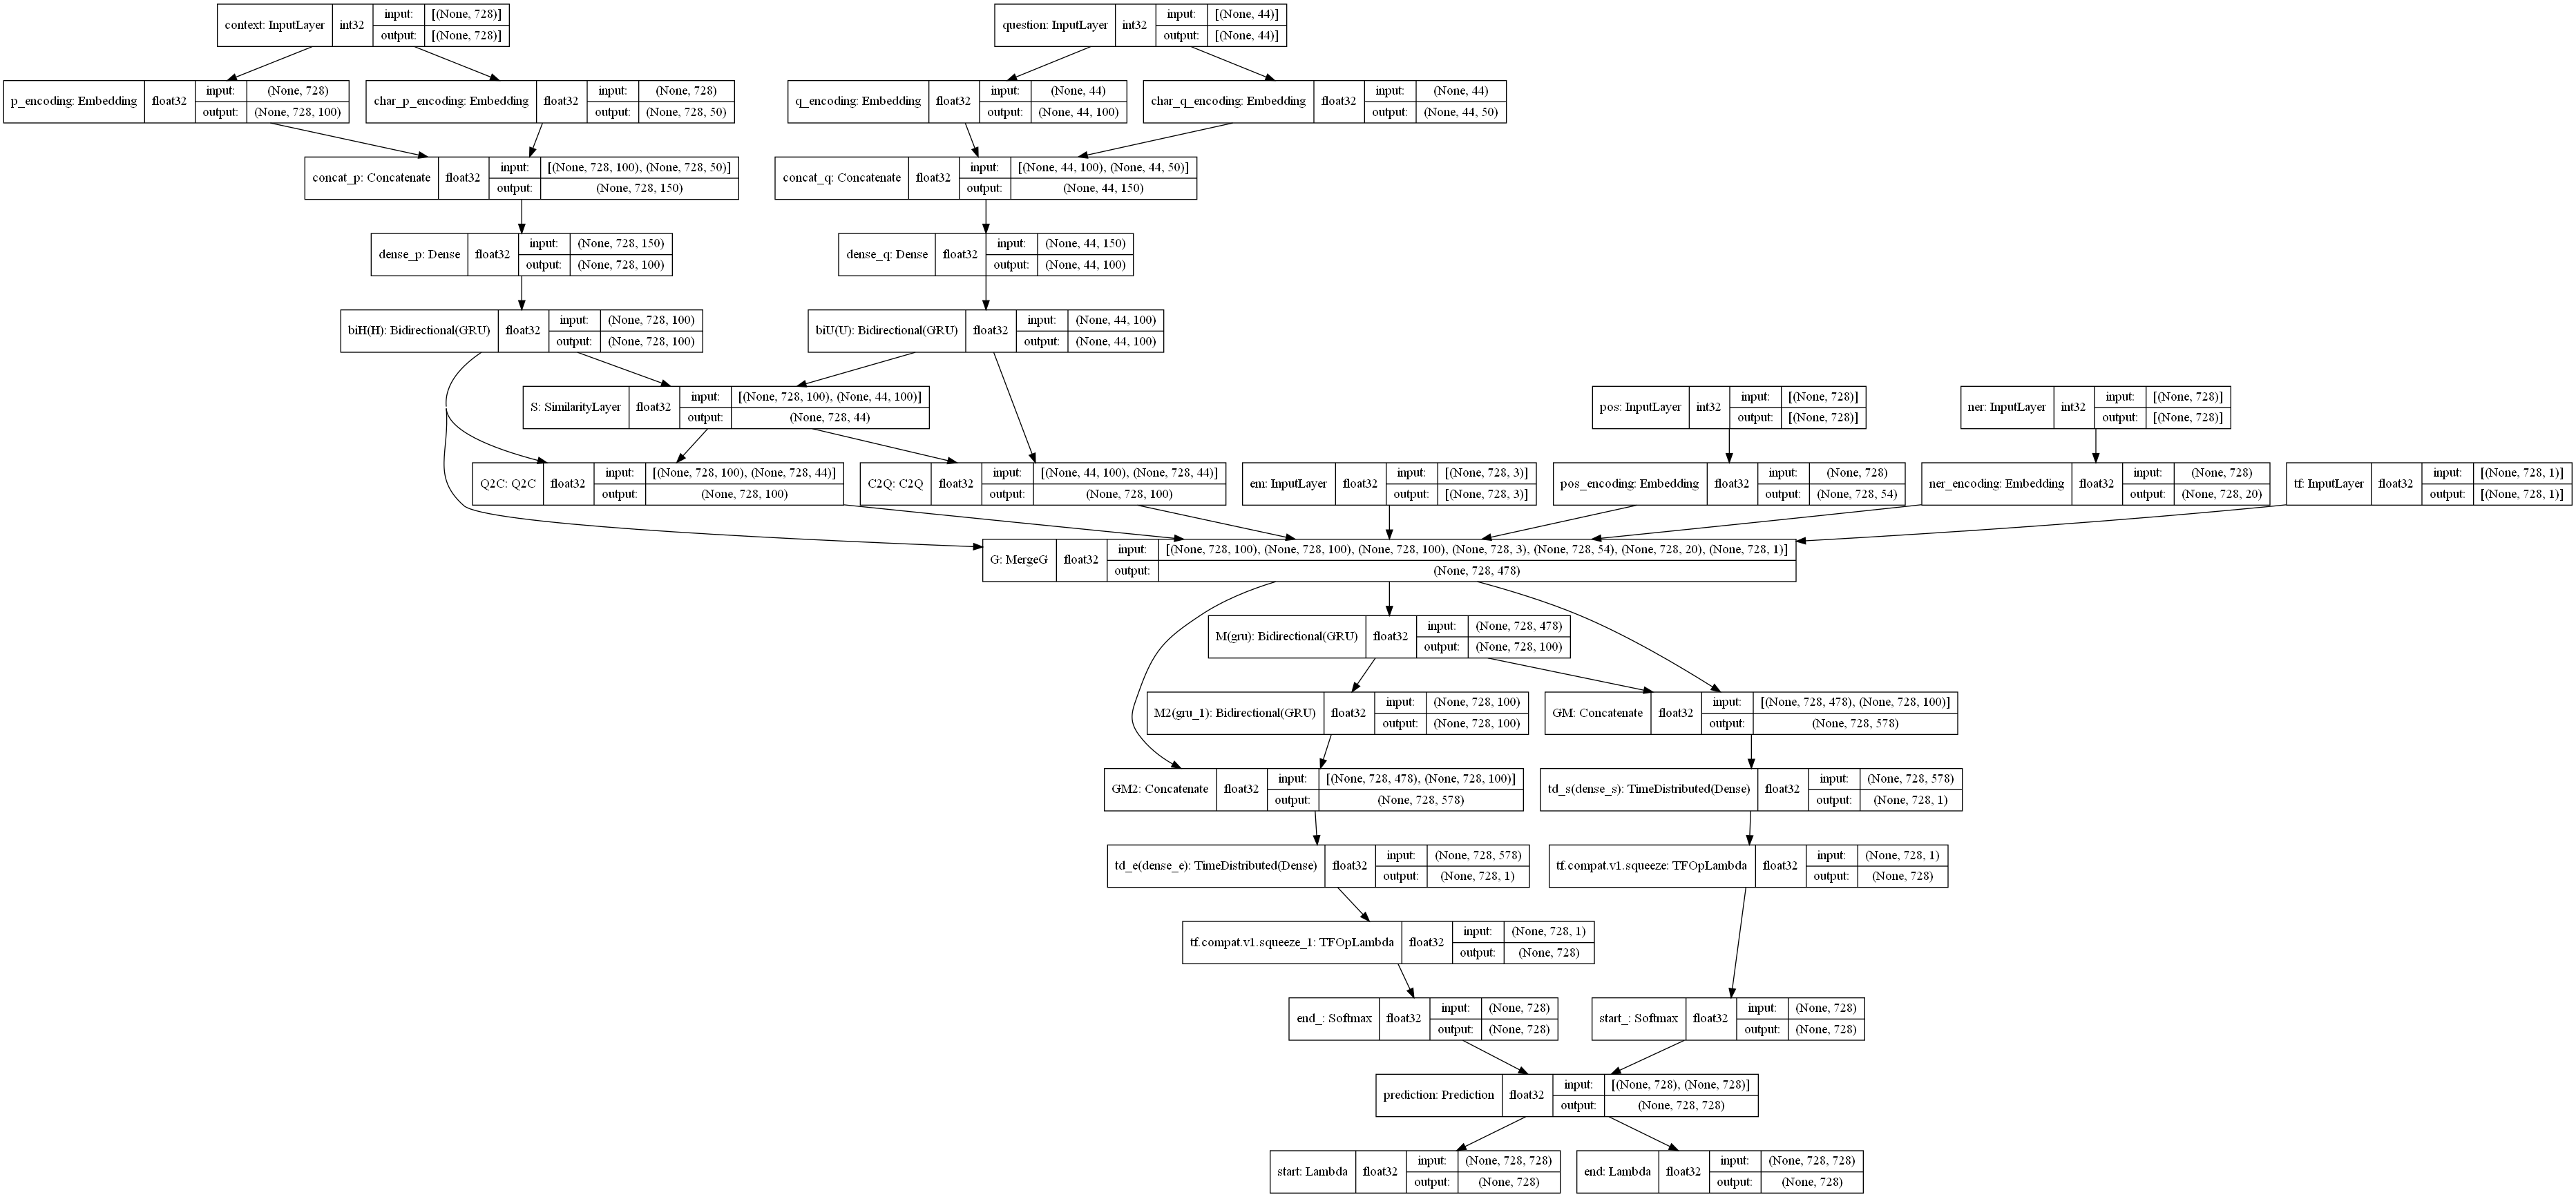

In [21]:
plot_model(model, rankdir='TB', show_shapes=True, show_dtype=True, to_file=f"{MODELS_DIR}/our_model.png")

In [22]:
import gc
gc.collect()

13092

### Training

In [29]:
mycb = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=25, batch_size=16, callbacks=[mycb])

Epoch 1/25
3822/3822 [==============================] - 911s 234ms/step - loss: 5.1447 - start_loss: 2.6949 - end_loss: 2.4498 - start_accuracy: 0.3388 - end_accuracy: 0.3623 - val_loss: 4.1108 - val_start_loss: 2.1638 - val_end_loss: 1.9471 - val_start_accuracy: 0.4300 - val_end_accuracy: 0.4728
Epoch 2/25
3822/3822 [==============================] - 910s 238ms/step - loss: 4.0183 - start_loss: 2.1353 - end_loss: 1.8829 - start_accuracy: 0.4442 - end_accuracy: 0.4837 - val_loss: 3.7222 - val_start_loss: 1.9643 - val_end_loss: 1.7578 - val_start_accuracy: 0.4731 - val_end_accuracy: 0.5122
Epoch 3/25
3822/3822 [==============================] - 938s 245ms/step - loss: 3.6900 - start_loss: 1.9631 - end_loss: 1.7269 - start_accuracy: 0.4781 - end_accuracy: 0.5182 - val_loss: 3.5922 - val_start_loss: 1.8983 - val_end_loss: 1.6940 - val_start_accuracy: 0.4884 - val_end_accuracy: 0.5286
Epoch 4/25
3822/3822 [==============================] - 932s 244ms/step - loss: 3.4846 - start_loss: 1.857

In [23]:
model.save_weights(f"{MODELS_DIR}/our_model_weights.h5")

### load model and evaluation

In [26]:
#model = our_model.build_model(MAX_QUESTION_LENGTH, MAX_CONTEXT_LENGTH, EMBEDDING_DIM,
#                                  embedding_matrix, char_embedding_matrix, pos_embedding_matrix, ner_embedding_matrix)
#model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics='accuracy')
model.load_weights(f"./{MODELS_DIR}/our_model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [27]:
print("Evalutating model on training set...")
evaluation = model.evaluate(x_tr, y_tr, batch_size=BATCH_SIZE)
print(evaluation)

Evalutating model on training set...
3822/3822 [==============================] - 264s 69ms/step - loss: 2.5888 - start_loss: 1.4000 - end_loss: 1.1887 - start_accuracy: 0.6072 - end_accuracy: 0.6514
[2.588776111602783, 1.4000362157821655, 1.188738465309143, 0.6071668267250061, 0.6513746380805969]


In [28]:
print("Evalutating model on validation set...")
evaluation = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)
print(evaluation)

Evalutating model on validation set...
1064/1064 [==============================] - 75s 70ms/step - loss: 3.3803 - start_loss: 1.7812 - end_loss: 1.5990 - start_accuracy: 0.5158 - end_accuracy: 0.5552
[3.3802881240844727, 1.7812402248382568, 1.599044919013977, 0.5158067941665649, 0.555176854133606]


In [30]:
test_df1 = test_df.copy()
test_df1, ts_contexts1 = preprocess.apply_preprocessing(test_df1, PREPROCESSING_PIPELINE1)

ts_context_padded = utils.pad(test_df1.context, df_tokenizer, MAX_CONTEXT_LENGTH)
ts_answer_padded = utils.pad(test_df1.text, df_tokenizer, MAX_TEXT_LENGTH)
ts_question_padded = utils.pad(test_df1.question, df_tokenizer, MAX_QUESTION_LENGTH)

test_df1['s_idx'] = test_df.apply(
    lambda x: len(preprocess.preprocessing(x.context[:x.answer_start], PREPROCESSING_PIPELINE1).split()), axis=1)
test_df1['e_idx'] = test_df1.apply(lambda x: x.s_idx + len(x.text.split()) - 1, axis=1)

ts_s_one = one_hot(test_df1.s_idx, depth=MAX_CONTEXT_LENGTH)
ts_e_one = one_hot(test_df1.e_idx, depth=MAX_CONTEXT_LENGTH)

ts_contexts = pd.DataFrame(test_df.context.unique(), columns=['context'])

ts_em_input = utils.compute_exact_match(test_df1, MAX_CONTEXT_LENGTH)
ts_tf_input = utils.compute_tf(test_df1, MAX_CONTEXT_LENGTH)
ts_pos_input = utils.compute_pos(test_df1, ts_contexts1, tag2idx, MAX_CONTEXT_LENGTH)
ts_ner_input = utils.compute_ner(test_df1, ts_contexts1, ts_contexts, ner2idx, MAX_CONTEXT_LENGTH)

x_ts = {'context': ts_context_padded, 'question': ts_question_padded, 'pos': ts_pos_input,
        'ner': ts_ner_input, 'em': ts_em_input, 'tf': ts_tf_input}
y_ts = {'start': ts_s_one, 'end': ts_e_one}

Computing original exact match...
Computing lowercase exact match...
Computing lemmatized exact match...
Computing TF...
Computing POS tags...
Padding POS sequences...
Computing NER tags...
Padding NER sequences...


In [31]:
print("Evalutating model on test set...")
evaluation = model.evaluate(x_ts, y_ts, batch_size=BATCH_SIZE)
print(evaluation)

Evalutating model on test set...
590/590 [==============================] - 42s 70ms/step - loss: 4.1751 - start_loss: 2.1082 - end_loss: 2.0669 - start_accuracy: 0.4836 - end_accuracy: 0.4926
[4.175075531005859, 2.108175039291382, 2.0668997764587402, 0.48357704281806946, 0.49258318543434143]


### Precision, recall, f1 by using indices

In [32]:
val_f1, val_precision, val_recall, _, _, _ = utils.evaluate_model(model, MAX_CONTEXT_LENGTH, val_df1, x_val)
print(f"F1: {val_f1}\t Precision: {val_precision}\t Recall: {val_recall}\t")

Computing F1 score, precision and recall...
F1: 0.5917964846088412	 Precision: 0.6211203747415406	 Recall: 0.6177622160795369	


In [33]:
gc.collect()

1000

In [34]:
ts_f1, ts_precision, ts_recall, _, _, _ = utils.evaluate_model(model, MAX_CONTEXT_LENGTH, test_df1, x_ts)
print(f"F1: {ts_f1}\t Precision: {ts_precision}\t Recall: {ts_recall}\t")

Computing F1 score, precision and recall...
F1: 0.5117103573149041	 Precision: 0.49471903873127654	 Recall: 0.5742279185461003	


In [35]:
gc.collect()

1029

In [36]:
tr_f1, tr_precision, tr_recall, _,_,_ = utils.evaluate_model(model, MAX_CONTEXT_LENGTH, train_df1, x_tr)
print(f"F1: {tr_f1}\t Precision: {tr_precision}\t Recall: {tr_recall}\t")

Computing F1 score, precision and recall...
F1: 0.6881615316909747	 Precision: 0.7292492826697479	 Recall: 0.7112992064260949	


In [56]:
gc.collect()

37460

### Some plots

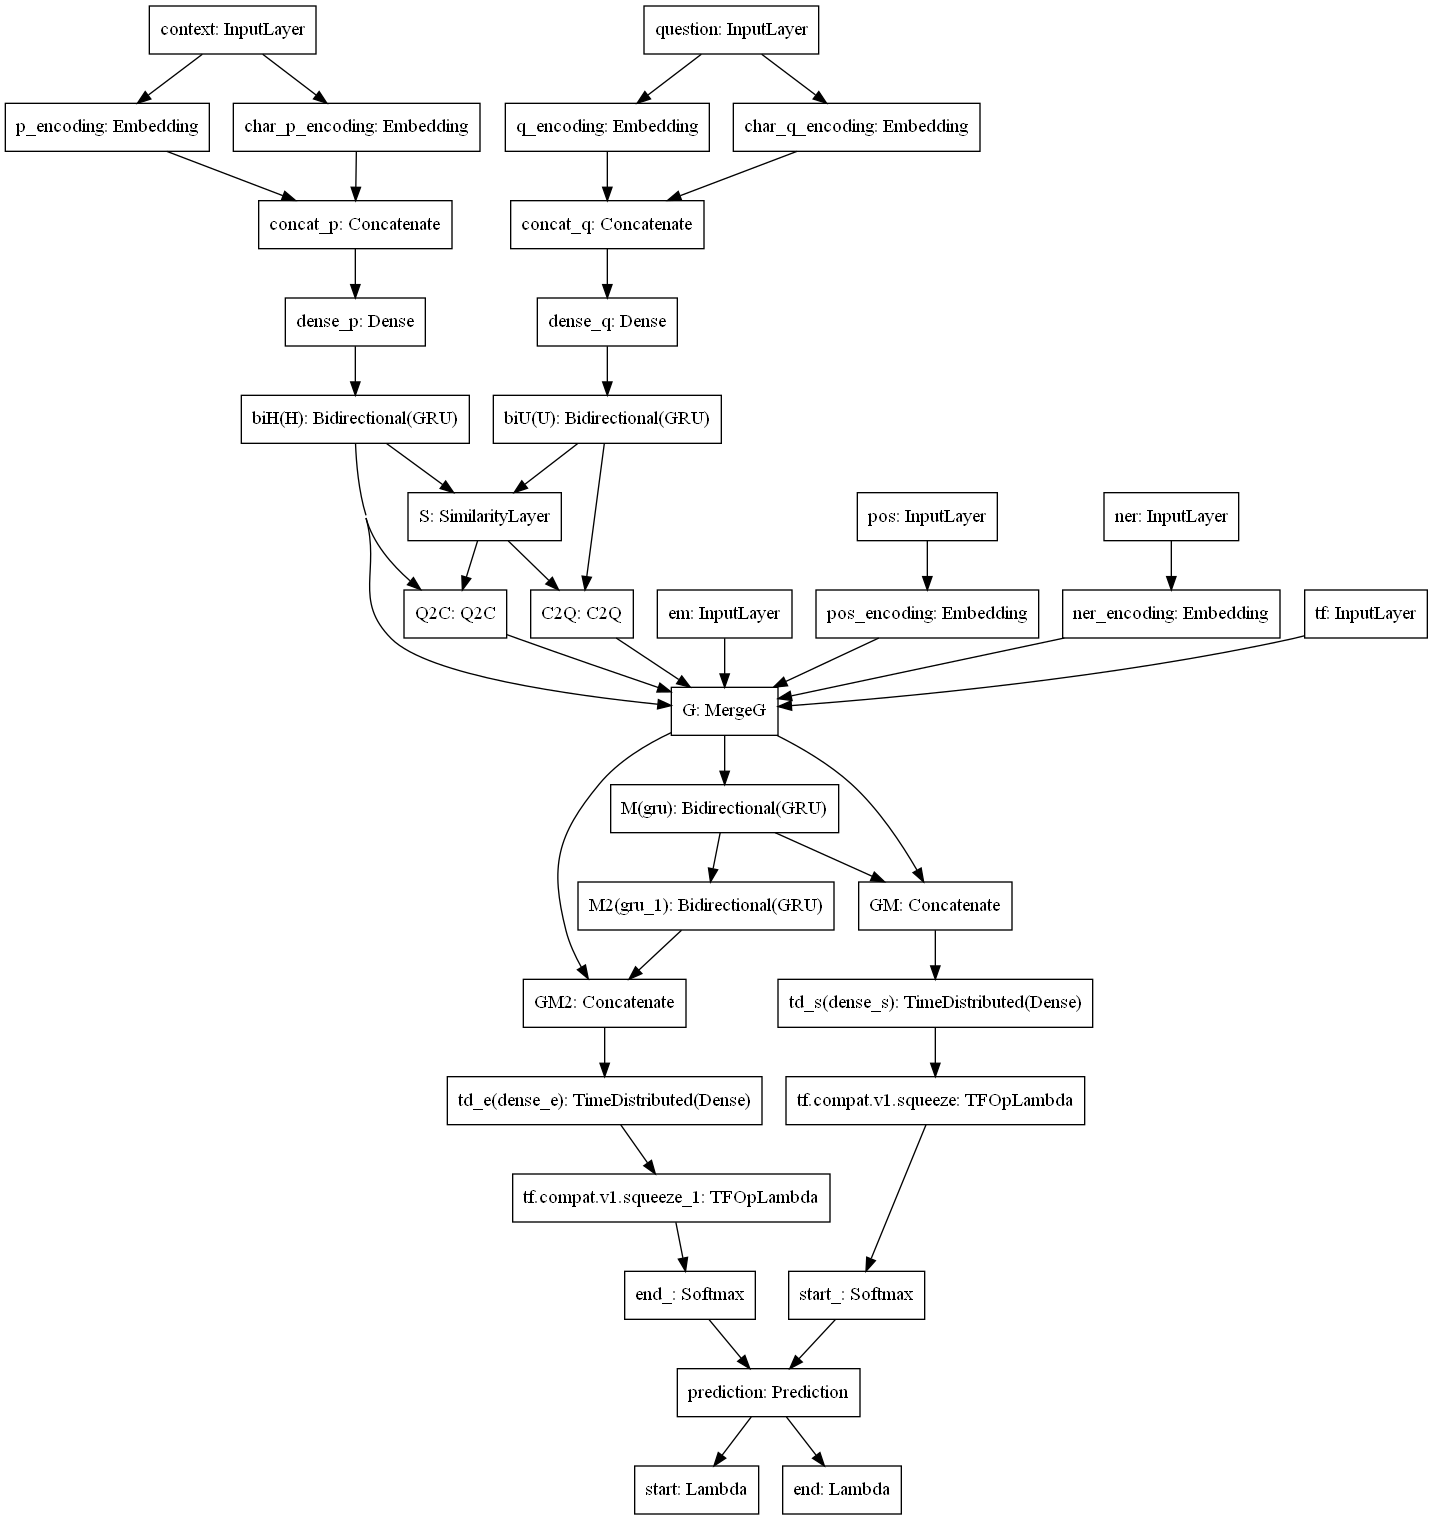

In [39]:
plot_model(model, rankdir='TB', show_shapes=False, show_dtype=False, to_file=f"{MODELS_DIR}/our_model2.png")

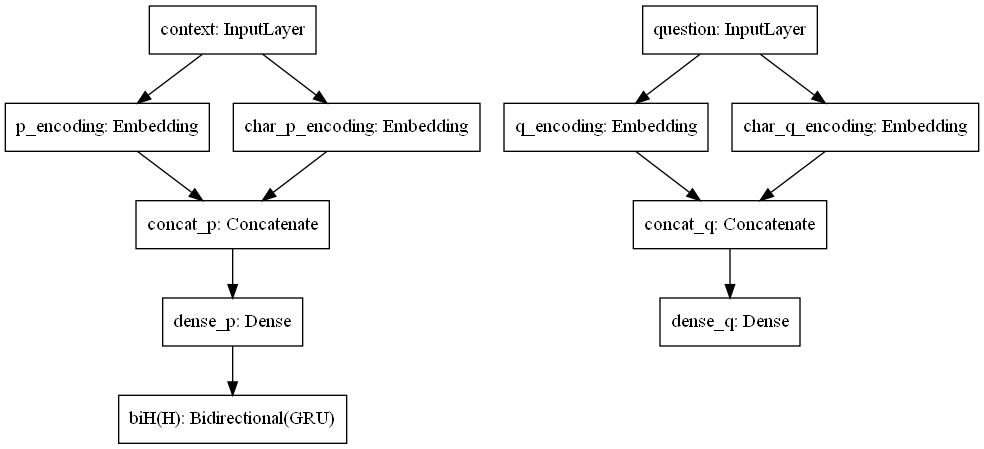

In [47]:
plot_model(model, rankdir='TB', show_shapes=False, show_dtype=False, to_file=f"{MODELS_DIR}/our_model3.png",
          layer_range=['context', 'biH'])

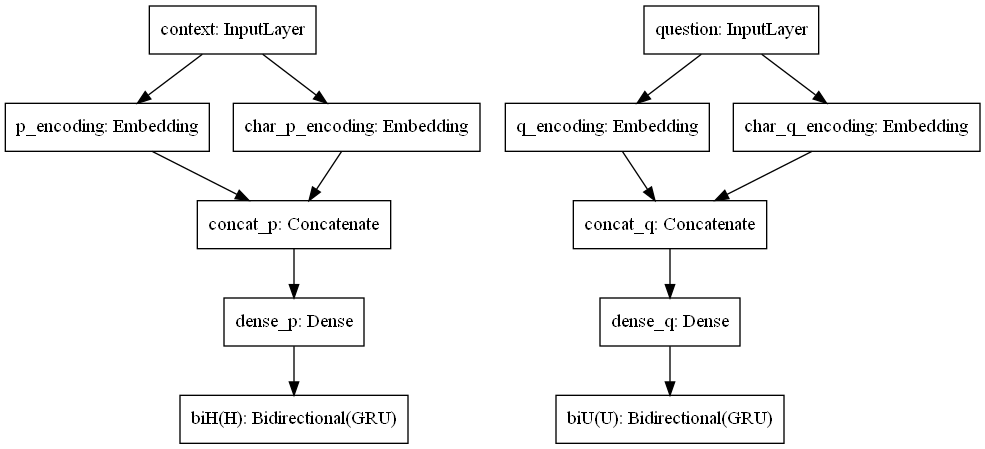

In [48]:
plot_model(model, rankdir='TB', show_shapes=False, show_dtype=False, to_file=f"{MODELS_DIR}/our_model4.png",
          layer_range=['context', 'biU'])

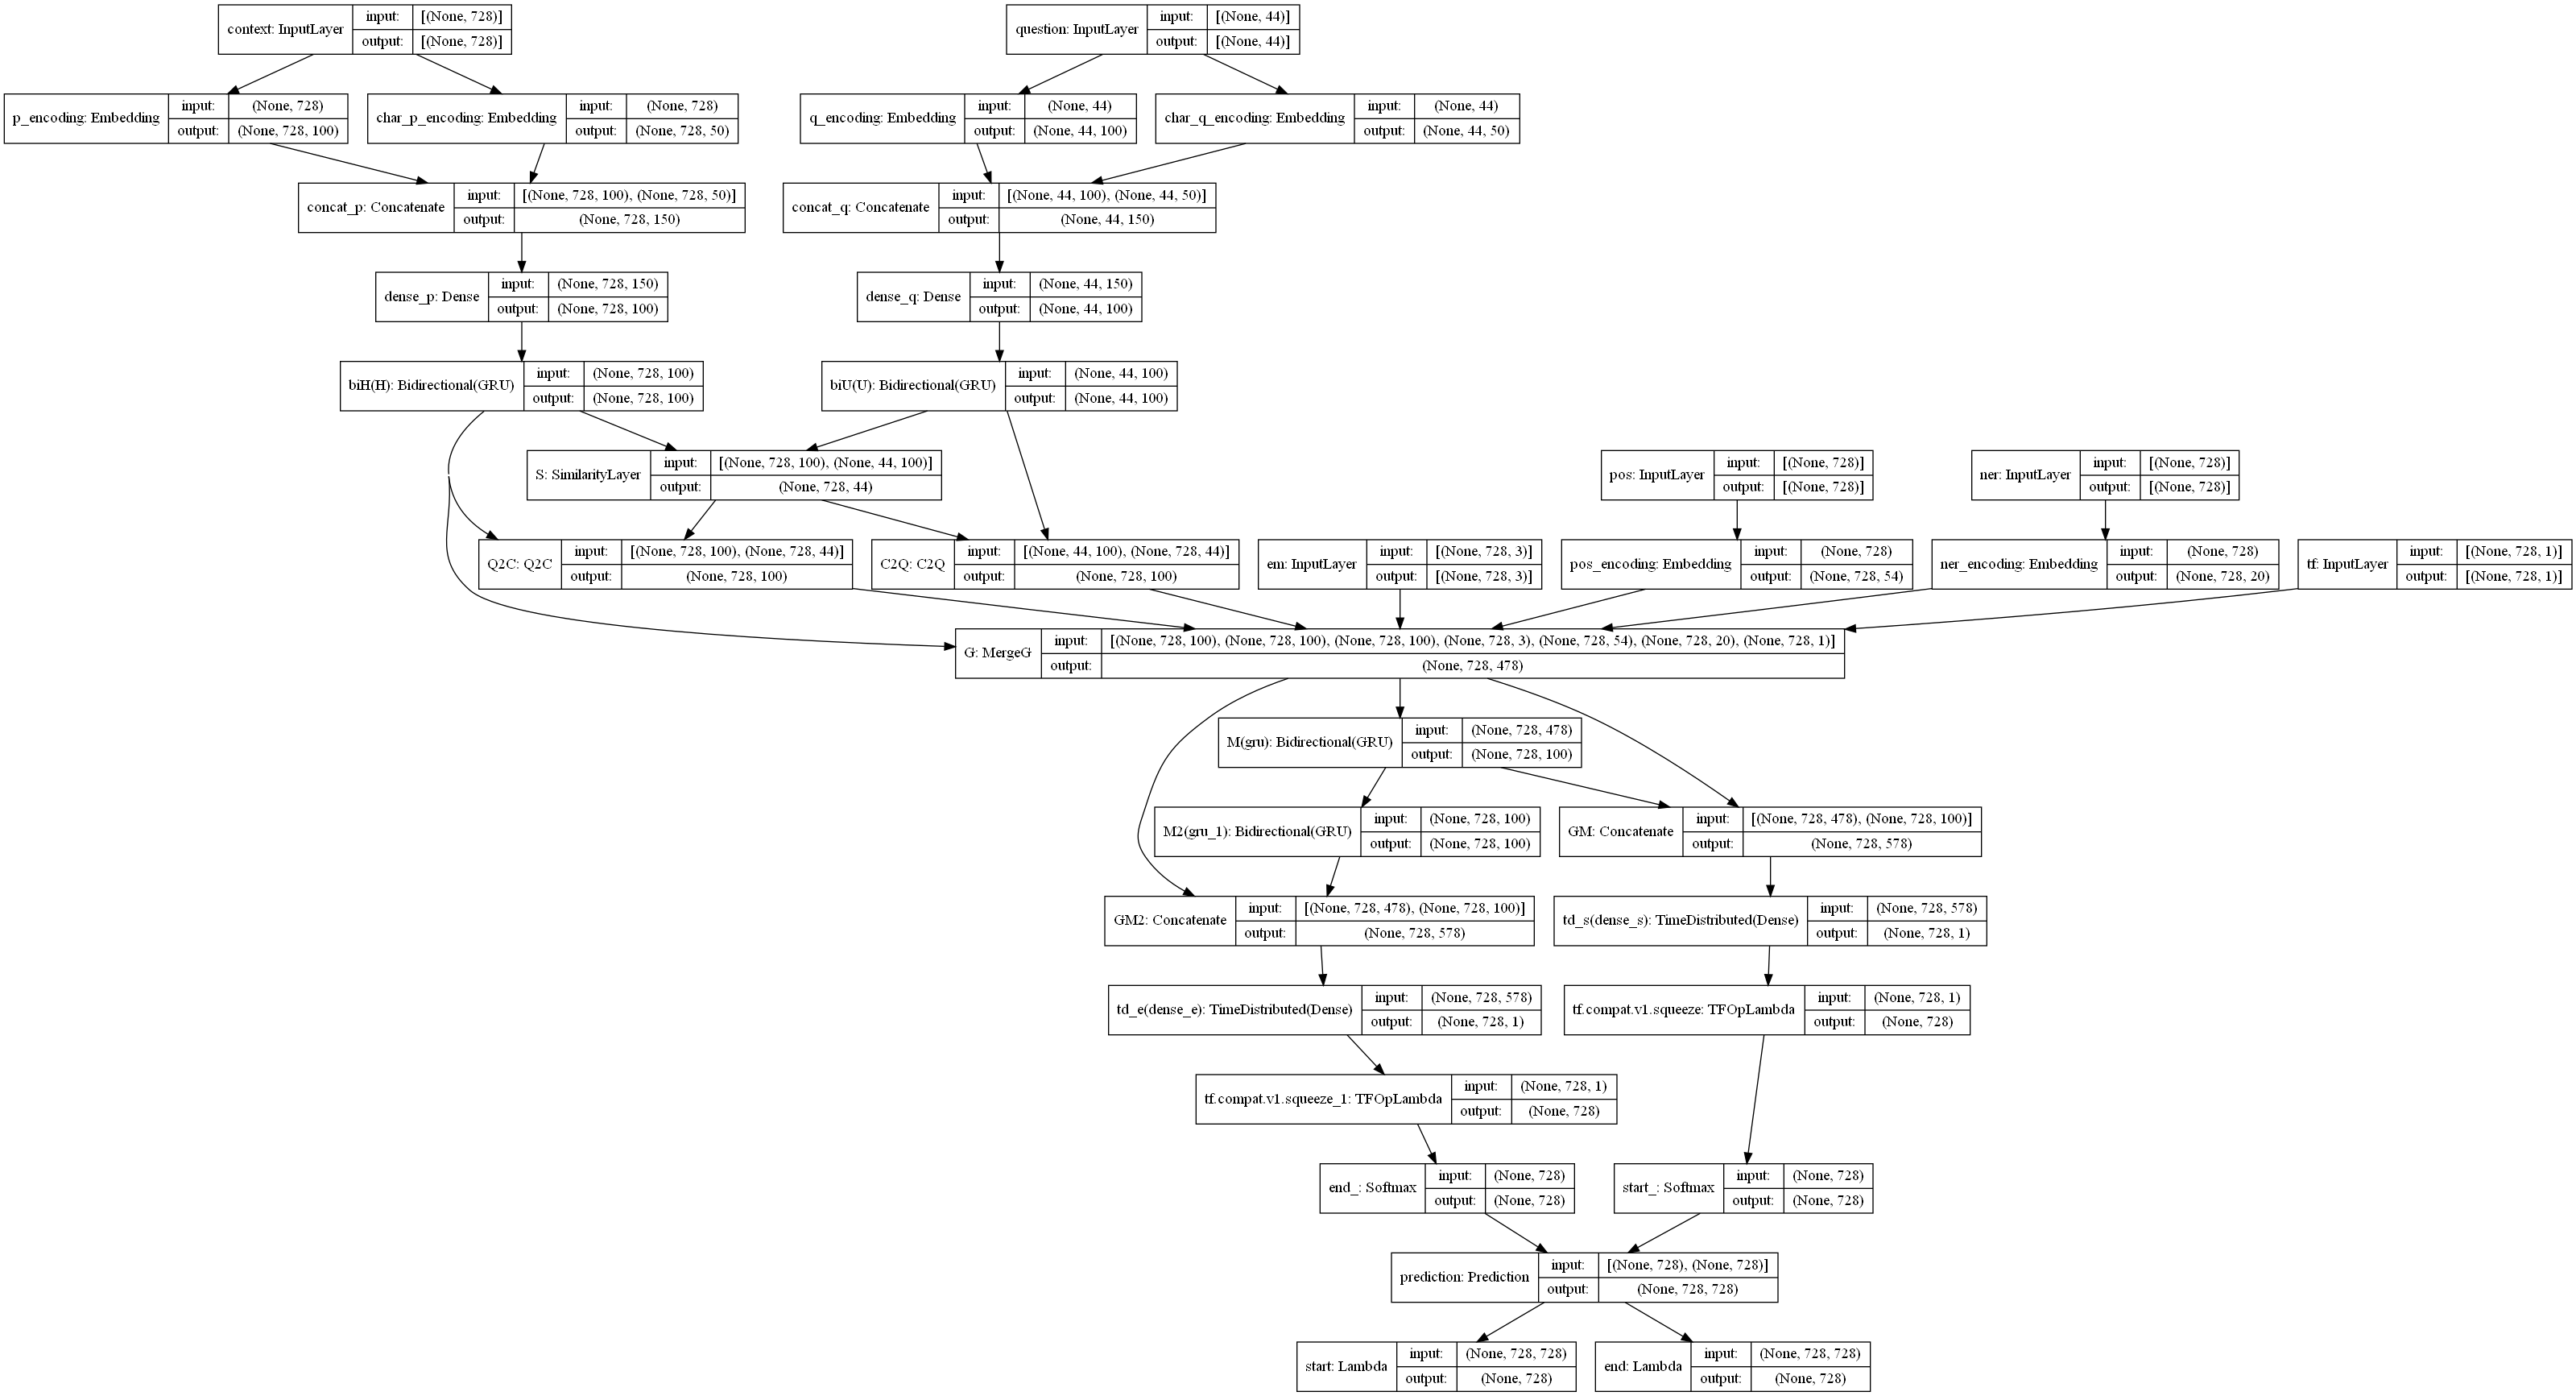

In [57]:
plot_model(model, rankdir='TB', show_shapes=True, show_dtype=False, to_file=f"{MODELS_DIR}/our_model4.png")

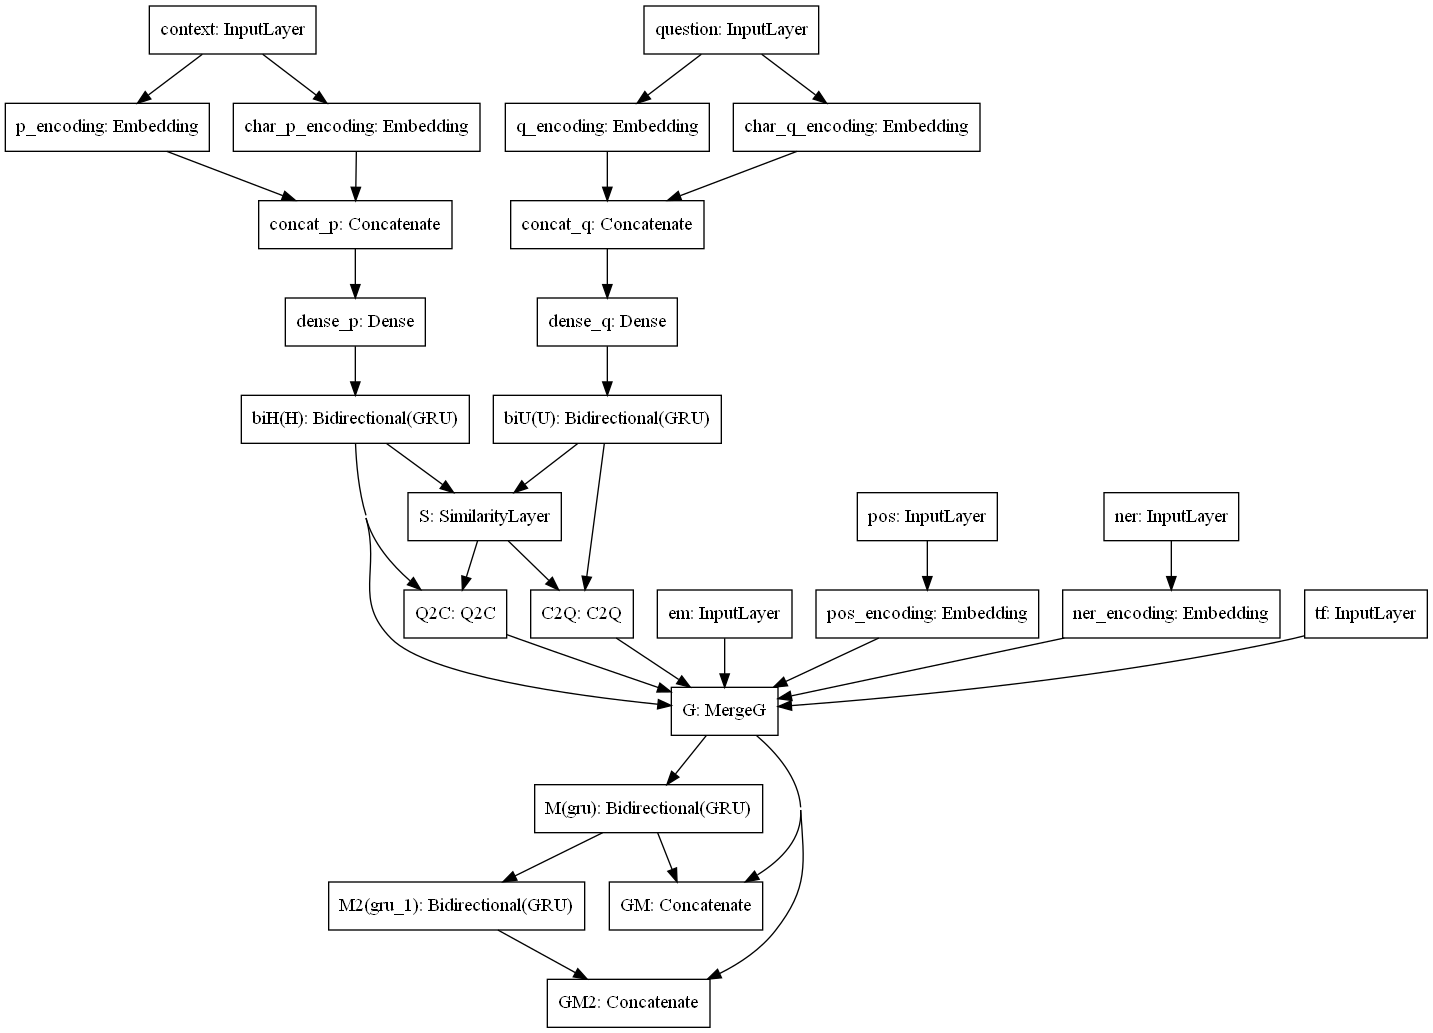

In [53]:
plot_model(model, rankdir='TB', show_shapes=False, show_dtype=False, to_file=f"{MODELS_DIR}/our_model5.png",
          layer_range=['context', 'G'])